In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ***Theory***

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
target = pd.DataFrame({'Label': data.target.tolist()}, index=range(len(data.target.tolist())))
target.replace({0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}, inplace=True)
features = pd.DataFrame({'sepal_length': data.data[:,0].tolist(), 'sepal_width': data.data[:,1].tolist(),
                         'petal_length': data.data[:,2].tolist(), 'petal_width': data.data[:,-1].tolist()}, index=range(len(data.data[:, 0].tolist())))

df = pd.concat([features, target], axis=1)

In [3]:
from sklearn.model_selection import train_test_split

X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y= df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, K, n_iters=5):
        self.k = K
        self.max_iter = int(n_iters)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i], 
                allow_singular=True)
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

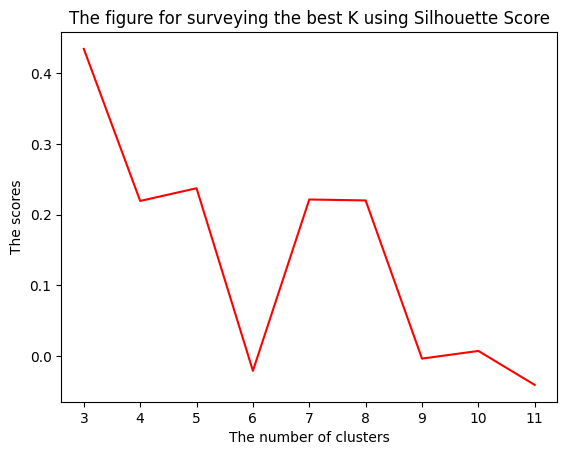

In [5]:
# Choose best K
from sklearn.metrics import silhouette_score

scores = []
for i in range(3, 12):
    gmm = GMM(K=i, n_iters=10)
    gmm.fit(X_train.to_numpy())
    
    predict = gmm.predict(X_train.to_numpy())
    metrics = silhouette_score(X_train.to_numpy(), predict)
    scores.append(metrics)

plt.plot(range(3, 12), scores, color='red')
plt.title('The figure for surveying the best K using Silhouette Score')
plt.xlabel('The number of clusters')
plt.ylabel('The scores')
plt.show()

In [6]:
# Choose the best K is 3
gmm = GMM(K=3, n_iters=100)
# gmm.initilize(X_train.to_numpy())
gmm.fit(X_train.to_numpy())

In [7]:
predict = gmm.predict(X_test.to_numpy())

In [8]:
# Range: (-1, 1)
from sklearn.metrics import silhouette_score

silhouette_score(X_test.to_numpy(), predict)

0.40741347510584686

In [162]:
y_test.replace({'Iris-Setosa': 0, 'Iris-Versicolour': 1, 'Iris-Virginica': 2}, inplace=True)

In [163]:
df_truth_visualize = pd.concat([X_test, y_test], axis=1)

In [164]:
df_truth_visualize

,sepal_length,sepal_width,petal_length,petal_width,Label
104,6.5,3.0,5.8,2.2,2
127,6.1,3.0,4.9,1.8,2
38,4.4,3.0,1.3,0.2,0
33,5.5,4.2,1.4,0.2,0
94,5.6,2.7,4.2,1.3,1
24,4.8,3.4,1.9,0.2,0
0,5.1,3.5,1.4,0.2,0
108,6.7,2.5,5.8,1.8,2
145,6.7,3.0,5.2,2.3,2
139,6.9,3.1,5.4,2.1,2


In [165]:
df_predict_visualize = pd.concat([X_test.reset_index(), pd.Series(predict, name='prediction')], axis=1)
df_predict_visualize.drop(columns='index', inplace=True)
df_predict_visualize

,sepal_length,sepal_width,petal_length,petal_width,prediction
0,6.5,3.0,5.8,2.2,1
1,6.1,3.0,4.9,1.8,1
2,4.4,3.0,1.3,0.2,0
3,5.5,4.2,1.4,0.2,0
4,5.6,2.7,4.2,1.3,1
5,4.8,3.4,1.9,0.2,0
6,5.1,3.5,1.4,0.2,0
7,6.7,2.5,5.8,1.8,1
8,6.7,3.0,5.2,2.3,1
9,6.9,3.1,5.4,2.1,1


Text(0.5, 1.0, 'The ground truth of dataset')

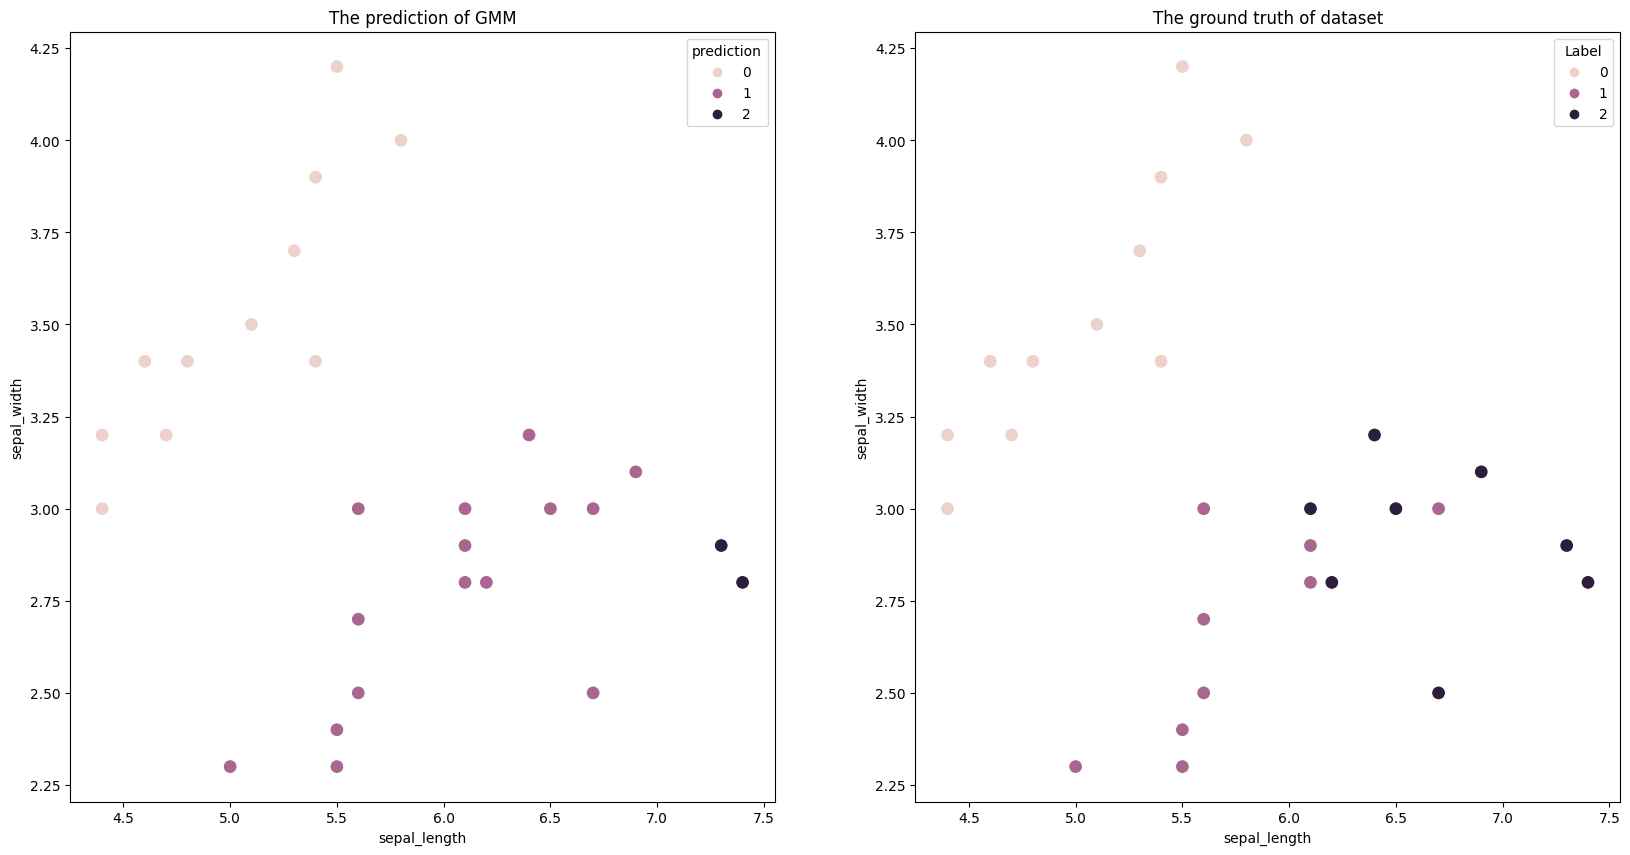

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.scatterplot(data=df_predict_visualize, x=df_predict_visualize.columns.tolist()[0], y=df_predict_visualize.columns.tolist()[1], hue='prediction', s=100, ax=ax[0])
ax[0].set_title('The prediction of GMM')
sns.scatterplot(data=df_truth_visualize, x=df_truth_visualize.columns.tolist()[0], y=df_truth_visualize.columns.tolist()[1], hue='Label', s=100, ax=ax[1])
ax[1].set_title('The ground truth of dataset')

In [168]:
from sklearn.metrics import accuracy_score
accuracy_score(df_predict_visualize['prediction'], df_truth_visualize['Label'])

0.7333333333333333

# ***Image Segementation***

In [17]:
import cv2
import os

ROOT = os.getcwd()
WORK_DIR = os.path.dirname(ROOT)
image = cv2.imread(os.path.join(WORK_DIR, 'images/traffic.jpg'))

In [23]:
image.shape

(408, 612, 3)

(-0.5, 611.5, 407.5, -0.5)

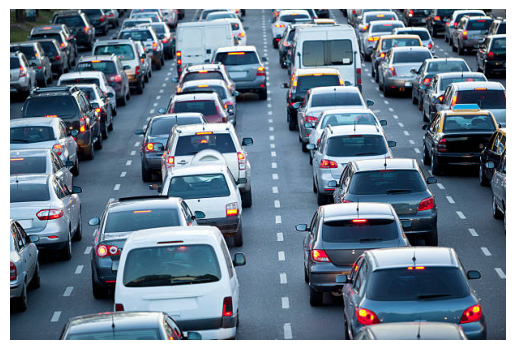

In [24]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [174]:
def displot(image, bins=51, ax=None):
    channel = image.shape[-1]
    
    for c in range(channel):
        color_data = image[:, :, c].reshape(image.shape[0]*image.shape[1], 1)
        if ax is None:
            plt.hist(color_data, bins=bins, alpha=0.7)
        else:
            ax.hist(color_data, bins=bins, alpha=0.7)
        
    plt.show()

In [65]:
normalized_image = (image.reshape(image.shape[0] * image.shape[1], 3) - image.reshape(image.shape[0] * image.shape[1], 3).mean()) / (image.reshape(image.shape[0] * image.shape[1], 3).max() - image.reshape(image.shape[0] * image.shape[1], 3).min())

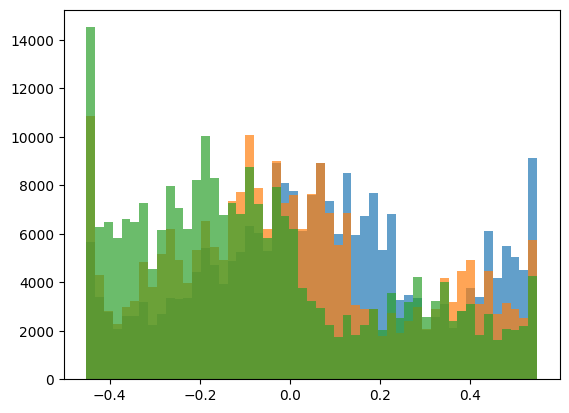

In [67]:
displot(normalized_image.reshape(image.shape))

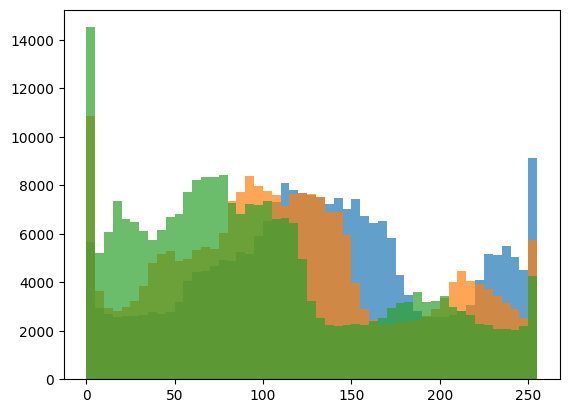

In [57]:
displot(image)

In [ ]:
# Choose best K
from sklearn.metrics import silhouette_score
import tqdm

scores = []
for i in tqdm.tqdm(range(3, 12)):
    gmm = GMM(K=i, n_iters=10)
    gmm.fit(normalized_image)
    
    predict = gmm.predict(normalized_image)
    metrics = silhouette_score(normalized_image, predict)
    scores.append(metrics)

In [ ]:
plt.plot(range(3, 12), scores, color='red')
plt.title('The figure for surveying the best K using Silhouette Score')
plt.xlabel('The number of clusters')
plt.ylabel('The scores')
plt.show()

In [100]:
def resized_image(normalized_image, shape):
    return normalized_image.reshape(shape)


def train_image_segmentation(model, image):
    gmm = model(K=3, n_iters=50)
    gmm.fit(image)
    return gmm

def test_image_segmentation(model, image):
    predict = model.predict(image)
    return predict

In [115]:
transposed_image = resized_image(image, (image.shape[0] * image.shape[1], 3))

In [101]:
model = train_image_segmentation(GMM, transposed_image)

In [167]:
label = test_image_segmentation(model, transposed_image)

In [168]:
predicted_image = label.reshape(image.shape[0], image.shape[1], 1)

(-0.5, 611.5, 407.5, -0.5)

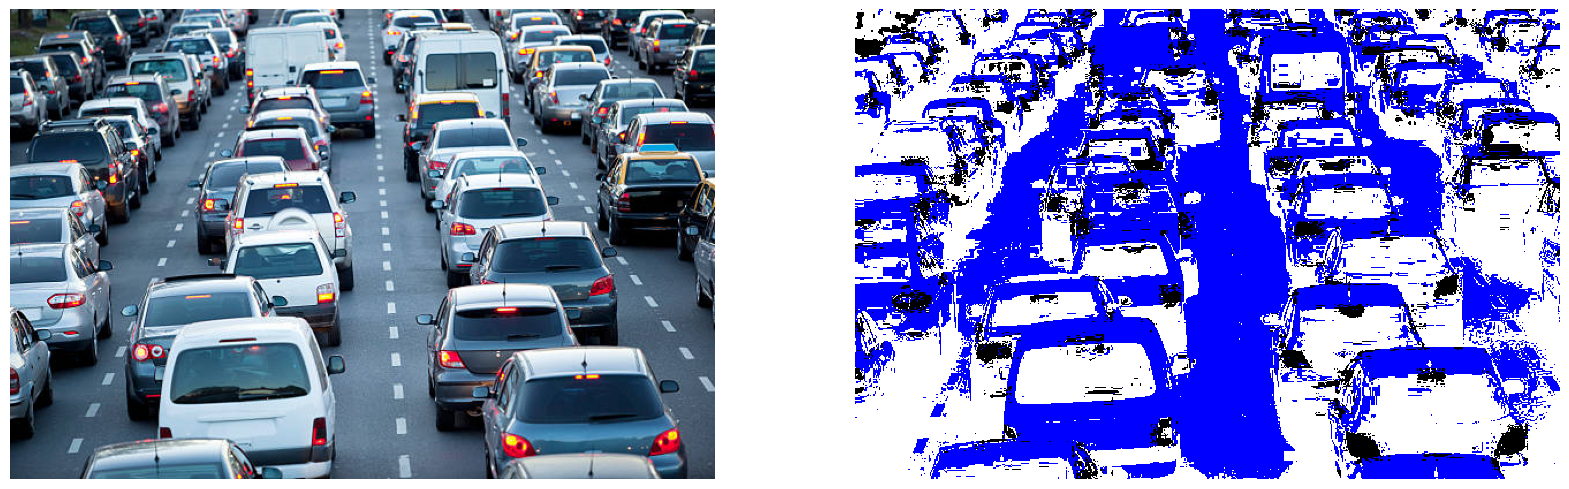

In [184]:
from matplotlib.colors import ListedColormap

colors = ['black', 'white', 'blue']
cmap = ListedColormap(colors)


fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].axis('off')

ax[1].imshow(predicted_image, cmap=cmap, interpolation='nearest')
ax[1].axis('off')